<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Superposition and Entanglement*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Córcoles

## Introduction
Many people tend to think quantum physics is hard math. This is actually not true, quantum concepts are very similar to linear algebra classes you probably did in first year university or even at high school. What is hard about quantum physics is that there is no simple underlying theory. Instead, you need to accept counter-intuitive ideas. In putting together the QX, we feel that you can get far by understanding two principles. 
1. A physical system in a perfectly definite state can still behave randomly.
2. Two systems that are too far apart to influence each other can nevertheless behave in ways that, though individually random, are somehow strongly correlated.

## Getting Started
Please see the [Getting Started with QISKit](tutorial4developer.ipynb) if you would like to understand the QISKit SDK better. However for this script simply work your way though the tutorial.  

In [1]:
#Checking the version of PYTHON we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
#usefull additional packages 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
%matplotlib inline
import time

import sys
sys.path.append("../../")
#importing the QISKit
from qiskit import QuantumProgram
import Qconfig

#import basic plot tools
from qiskit.basicplotter import plot_histogram

## Quantum States - basis states and superpositions

Principle 1 says that by measuring quantum states in different bases, we can get results that can be random or deterministic. To show this, we will start by introducing the computational basis (or standard basis) for a qubit. 

The computational (or standard) basis for a qubit is $\{|0\rangle,|1\rangle\}$, which correspond to the following vectors: 

$$|0\rangle =\begin{pmatrix} 1 \\ 0 \end{pmatrix}$$
$$|1\rangle =\begin{pmatrix} 0 \\ 1 \end{pmatrix}$$

In python these are represented by

In [2]:
zero = np.array([[1],[0]])
one = np.array([[0],[1]])

In our system and many physical devices it is natural for all the qubits to start in the $|0\rangle$ state which is often called the ground state. To make the $|1\rangle$ state (or excited state) we use the operator 

$$ X =\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$$

which is often called a bit-flip because it implements exactly this:

$$X: |0\rangle  \rightarrow  |1\rangle$$
$$X: |1\rangle \rightarrow |0\rangle$$

In python this can be represented by the following 

In [3]:
X = np.array([[0,1],[1,0]])
print(np.dot(X,zero))
print(np.dot(X,one))

[[0]
 [1]]
[[1]
 [0]]


Bellow we give the two quantum circuits for making the ground and exicted state using the QX. The first part uses QISKit to make the two circuits

In [4]:
device = 'qx5qv2' # the device to run on
shots = 1024    #the number of shots in the experiment. 

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) #set the APIToken and API url


# Creating Registers
qr = Q_program.create_quantum_registers("qr", 1)
cr = Q_program.create_classical_registers("cr", 1)

#Quantum circuit ground 
qc_ground = Q_program.create_circuit("ground", ["qr"], ["cr"])
qc_ground.measure(qr[0], cr[0])

#Quantum circuit excited 
qc_excited = Q_program.create_circuit("excited", ["qr"], ["cr"])
qc_excited.x(qr)
qc_excited.measure(qr[0], cr[0])

print(Q_program.program_to_text())

>> quantum_registers created: qr 1
>> classical_registers created: cr 1
OPENQASM 2.0;
include "qelib1.inc";
qreg qr[1];
creg cr[1];
u3(3.141592653589793,0.0,3.141592653589793) qr[0];
measure qr[0] -> cr[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg qr[1];
creg cr[1];
measure qr[0] -> cr[0];


Next we run the batched jobs on the QX

In [5]:
circuits = [qc_ground, qc_excited]
results = Q_program.execute(circuits, device, shots, max_credits=3, wait=10, timeout=240)

status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
status = RUNNING (70 seconds)
status = RUNNING (80 seconds)
status = RUNNING (90 seconds)
status = RUNNING (100 seconds)
status = RUNNING (110 seconds)
status = RUNNING (120 seconds)
status = RUNNING (130 seconds)
status = RUNNING (140 seconds)
status = RUNNING (150 seconds)
status = RUNNING (160 seconds)
status = RUNNING (170 seconds)


Next the data is extracted from the API output and plotted

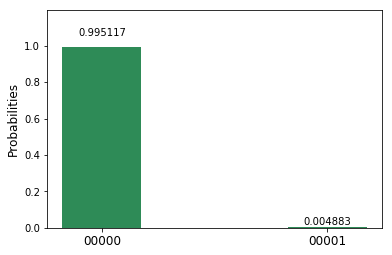

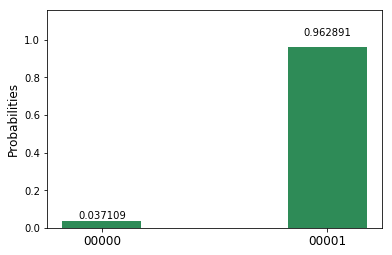

In [6]:
data0=Q_program.get_data(results,0)
plot_histogram(data0)
data1=Q_program.get_data(results,1)
plot_histogram(data1)

Here we see that with high probability the qubit is either in the $|0\rangle$ or $|1\rangle$ state respectively. The difference is a combination of measurement error, preparation error, and gate error (for the $|1\rangle$ state). 

So far there is nothing different to what you would expect classically. This is because we have not made a superpostion. To do this we indroduce the Hadamard gate, $H$. Let's assume for now that this gate is like flipping a coin. It has two outcomes and each occurs with equal probability. If we do this thought experiment, we say that on average we will measure as many heads as we do tails. Let heads be $|0\rangle$ and $|1\rangle$ be tails. 

Let's run the quantum version of this experiment. 

The experiment consists of first preparing the qubit in the ground state, then applying the Hadamard gate (coin flip), and then measuring the state of the qubit. Repeat the experiment 1024 times (shots). Correctly, you will predict half the outcomes will be in the $|0\rangle$ state and half will be in the $|1\rangle$ state.

Try the program below.

status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)


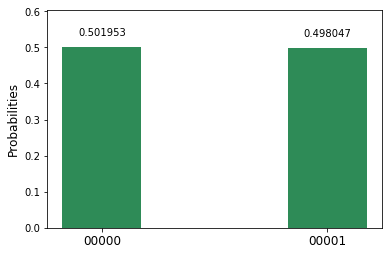

In [7]:
#Quantum circuit superposition 
qc_superposition = Q_program.create_circuit("superposition", ["qr"], ["cr"])
qc_superposition.h(qr)
qc_superposition.measure(qr[0], cr[0])

circuits = [qc_superposition]
results = Q_program.execute(circuits, device, shots, max_credits=3, wait=10, timeout=240)

plot_histogram(Q_program.get_data(results,0))

Here we see that, much like a coin flip, we get 50/50 within projective noise. Now let's run an experiment with two $H$ gates. If this was a coin flip, we would still predict a 50/50 distribution. Let's try the experiment!

status = RUNNING (10 seconds)
status = RUNNING (20 seconds)


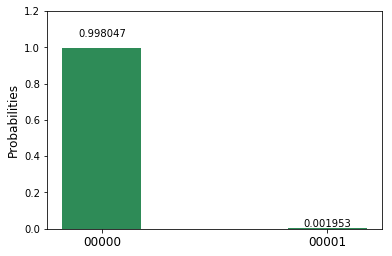

In [8]:
#Quantum circuit two Hadamard 
qc_twohadamard = Q_program.create_circuit("twohadamard", ["qr"], ["cr"])
qc_twohadamard.h(qr)
qc_twohadamard.barrier()
qc_twohadamard.h(qr)
qc_twohadamard.measure(qr[0], cr[0])

circuits = [qc_twohadamard]
results = Q_program.execute(circuits, device, shots, max_credits=3, wait=10, timeout=240)

plot_histogram(Q_program.get_data(results,0))

Here we see that, unlike the classical case, with high probability the outcome is all in the $|0\rangle$ state. This shows that quantum randomness is not like a classical coin flip. In both cases, the system (without noise) is in a definite state but only the first case behaves randomly. This is because, in the first case, we make a uniform superposition $(|0\rangle+|1\rangle)/\sqrt{2}$ and measure in the computational basis. In the second case, you can think of the second $H$ as changing the measurement basis from the computational to the superposition basis.
$$H: |0\rangle  \rightarrow  |+\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}}$$
$$H: |1\rangle \rightarrow |-\rangle=\frac{|0\rangle-|1\rangle}{\sqrt{2}}$$
Therefore, if the measurement gives 0, we can conclude that the system was in the $|+\rangle$ state before the second $H$ gate, and if we obtain 1, it means the system was in the $|-\rangle$ state. In the above experiment we see that the outcome is mainly 0, suggesting that our system was in the $|+\rangle$ superposition state before the second $H$ gate. 


The math is best understood if we represent the quantum superpostion state $|+\rangle$ and $|-\rangle$ by 

$$|+\rangle =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$$
$$|-\rangle =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ -1 \end{pmatrix}$$

A standard measurement, known in quantum mechanics as a projective or von Neumann measurement, takes any superposition state of the qubit and projects it to either the state $|0\rangle$  or the state $|1\rangle$ with a probability determined by:

$$P(i|\psi) = |\langle i|\psi\rangle|^2$$ 

where $P(i|\psi)$ is the probability of measuring the system in state $i$ given preparation $\psi$.

We have written the Python function StateOverlap to return this: 

In [9]:
state_overlap = lambda state1, state2: np.absolute(np.dot(state1.conj().T,state2))**2

Now that we have a simple way of going from a state to the probability distribution of a standard measurement, we can go back to the case of a superposition made from the Hadamard gate. The Hadamard gate is defined by the matrix:

$$ H =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

The $H$ gate acting on the state $|0\rangle$ gives:

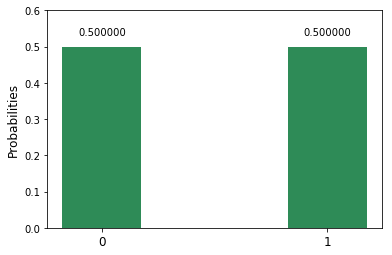

In [10]:
Hadamard = np.array([[1,1],[1,-1]],dtype=complex)/np.sqrt(2)
psi1 = np.dot(Hadamard,zero)
P0 = state_overlap(zero,psi1)
P1 = state_overlap(one,psi1)
plot_histogram({'0' : P0, '1' : P1})

which is the ideal version of the first experiment. 

The second experiment involves applying the Hadamard gate twice. While matrix multiplication shows that the product of two Hadamards is the identity operator, meaning that the state $|0\rangle$ remains unchanged, here we would rather interpret this as doing a measurement in the superposition basis. Using the above definitions, you can show that H transforms the computational basis to the superposition basis.

In [11]:
print(np.dot(Hadamard,zero))
print(np.dot(Hadamard,one))

[[ 0.70710678+0.j]
 [ 0.70710678+0.j]]
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]


## Entanglement

The core idea behind principle 2 is entanglement. Entanglement is not just perfect (classical) correlation. If you and I read the same paper we will have the same information, and if a third person comes along and reads the same paper they <i>also</i> will have this information. All these people are perfectly correlated. If we separate them, they will still remain correlated. 

If you and I read a quantum paper we will not learn what the paper says until we get together and share our information. However, when we are together we can ask more questions about this information than we initially thought possible. Thus, quantum entanglement goes much further than perfect correlation.

To demonstrate this we need to define the CNOT gate and the composition of two systems. The convention we use in the Quantum Experience is to label states by writing the first qubit's name in the rightmost position, thereby allowing us to easily convert from binary to decimal. This results in us defining the tensor product between operators $q_0$ and $q_1$ by $q_1\otimes q_0$. 

Taking $q_0$ as the control and $q_1$ as the target, the CNOT with this representation is given by

$$ CNOT =\begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{pmatrix},$$

which is non-standard in the quantum community but allows the best connection to classical computing, where the LSB is typically on the right.


Let's start by asking questions about the state of the qubits. The questions we can ask are:
* What is the state of the first qubit in the standard basis?
* What is the state of the first qubit in the superpostion basis?
* What is the state of the second qubit in the standard basis?
* What is the state of the second qubit in the superpostion basis?
* What is the state of both qubits in the standard basis?
* what is the staet of both qubits in the superpostion basis?

Below we have made a program that has 6 different circuits for these different questions

In [12]:
# Creating Registers
q2 = Q_program.create_quantum_registers("q2", 2)
c2 = Q_program.create_classical_registers("c2", 2)

#quantum circuit to make bell state 
bell = Q_program.create_circuit("bell", ["q2"], ["c2"])
bell.h(q2[0])
bell.cx(q2[0], q2[1])


#quantum circuit to measure q0 in standard basis
measureIZ = Q_program.create_circuit("measureIZ", ["q2"], ["c2"])
measureIZ.measure(q2[0], c2[0])

#quantum circuit to measure q0 in superposition basis 
measureIX = Q_program.create_circuit("measureIX", ["q2"], ["c2"])
measureIX.h(q2[0])
measureIX.measure(q2[0], c2[0])

#quantum circuit to measure q1 in standard basis
measureZI = Q_program.create_circuit("measureZI", ["q2"], ["c2"])
measureZI.measure(q2[1], c2[1])

#quantum circuit to measure q1 in superposition basis 
measureXI = Q_program.create_circuit("measureXI", ["q2"], ["c2"])
measureXI.h(q2[1])
measureXI.measure(q2[1], c2[1])

# quantum circuit to measure q in standard basis 
measureZZ = Q_program.create_circuit("measureZZ", ["q2"], ["c2"])
measureZZ.measure(q2[0], c2[0])
measureZZ.measure(q2[1], c2[1])

# quantum circuit to measure q in superposition basis 
measureXX = Q_program.create_circuit("measureXX", ["q2"], ["c2"])
measureXX.h(q2[0])
measureXX.h(q2[1])
measureXX.measure(q2[0], c2[0])
measureXX.measure(q2[1], c2[1])

circuits = [bell+measureIZ, bell+measureIX, bell+measureZI, bell+measureXI, bell+measureZZ, bell+measureXX]

print(Q_program.program_to_text(circuits))

>> quantum_registers created: q2 2
>> classical_registers created: c2 2
OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
u2(0.0,3.141592653589793) q2[0];
cx q2[0],q2[1];
measure q2[0] -> c2[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
u2(0.0,3.141592653589793) q2[0];
cx q2[0],q2[1];
u2(0.0,3.141592653589793) q2[0];
measure q2[0] -> c2[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
u2(0.0,3.141592653589793) q2[0];
cx q2[0],q2[1];
measure q2[1] -> c2[1];


OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
u2(0.0,3.141592653589793) q2[0];
cx q2[0],q2[1];
u2(0.0,3.141592653589793) q2[1];
measure q2[1] -> c2[1];


OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
u2(0.0,3.141592653589793) q2[0];
cx q2[0],q2[1];
measure q2[1] -> c2[1];
measure q2[0] -> c2[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
u2(0.0,3.141592653589793) q2[0];
cx q2[0],q2[1];
u2(0.0,3.141592653589793) q2[1];
measure q2[1] -> c2[1

Lets start by running the first two questions

status = RUNNING (10 seconds)
status = RUNNING (20 seconds)


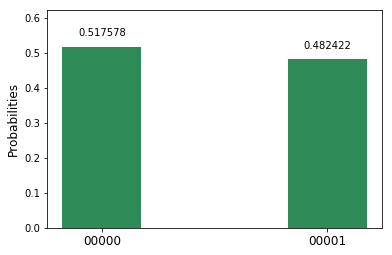

In [13]:
results = Q_program.execute(circuits[0:2], device, shots, max_credits=3, wait=10, timeout=240)
plot_histogram(Q_program.get_data(results,0))

Here we see that it is random. Half the time it is in the $|0\rangle$ and the other half is in the $|1\rangle$ state. But maybe it is like the superposition. Maybe the qubit has a perfectly definite state and we were measuring in another basis.  What would you expect if you did the experiment and measured in the superposition basis? Recall we do this by adding a $H$ gate before the measurement. Lets try it.

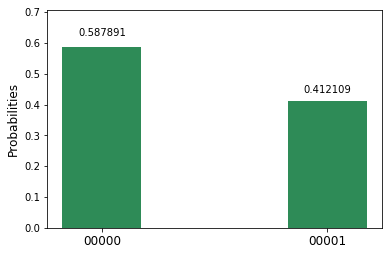

In [14]:
plot_histogram(Q_program.get_data(results,1))

Here we see again it is random. So it is both random when we measure the first qubit in the standard basis and in the superpostion basis. We know nothing about the first qubit. What about the second qubit? Below we run experiments that measure in the computational and superpostion basis of the second qubit.

status = RUNNING (10 seconds)
status = RUNNING (20 seconds)


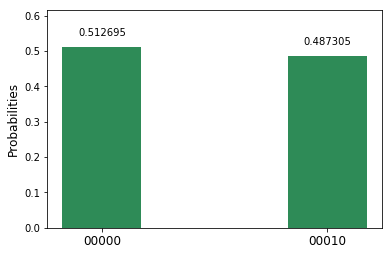

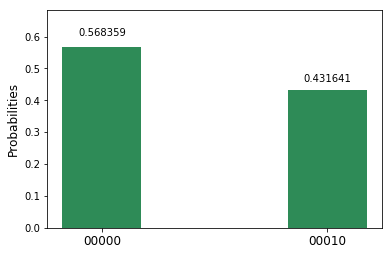

In [15]:
results = Q_program.execute(circuits[2:4], device, shots, max_credits=3, wait=10, timeout=240)
plot_histogram(Q_program.get_data(results,0))
plot_histogram(Q_program.get_data(results,1))

Again all the experiments give random outcomes. It seems we know nothing about our system. In the analogy above, this would be two different readers reading a quantum paper and extracting no information whatsoever from it.

However, if they'd get together and both measure in the computation basis what do you expect? 

In [16]:
results = Q_program.execute(circuits[4:6], device, shots, max_credits=3, wait=10, timeout=240)

status = RUNNING (10 seconds)
status = RUNNING (20 seconds)


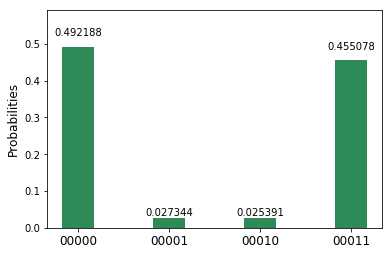

In [17]:
plot_histogram(Q_program.get_data(results,0))

Here we see that if with high probability if $q_0$ is in state 0 so is $q_1$ and same for state 1. They are perfectly correlated.

What about in the superposition basis? Lets run the experiment and see. 

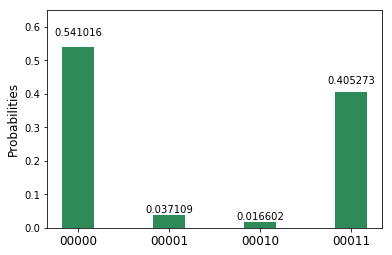

In [18]:
plot_histogram(Q_program.get_data(results,1)) 

Here we see that (up to experimental noise) the system has perfect correlations in both the computation basis and the superpostion basis. This means that if $q_0$ is measured in state $|0\rangle$ then we know $q_1$ is in this state, and furthermore if $q_0$ is measured in state $|+\rangle$ then we know $q_1$ is in this state. These correlations have lead to a lot of confusion in science mainly because we try to find analogies between the weird concept of quantum entanglement and everyday experiences and this leads inevitably to many inconsistencies.